In [ ]:
# Install required libraries
!pip install optuna tensorflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 738.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.3/262.3 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 156.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.9/609.9 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 160.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.5 MB/s eta 0:00:00


In [ ]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, Xception, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
from pathlib import Path

# Check GPU
print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))
if not tf.config.list_physical_devices('GPU'):
    print('⚠️  WARNING: No GPU detected! Enable T4 GPU in Runtime → Change runtime type')

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


TensorFlow version: 2.20.0
GPU available: []
⚠️  WARNING: No GPU detected! Enable T4 GPU in Runtime → Change runtime type


In [ ]:
import zipfile
import os

dataset_zip = 'enhanced_dataset.zip'
target_folder = 'enhanced_dataset'

print(f"Fixing structure: Extracting into '{target_folder}/'...")

# 1. Force extraction into the subfolder
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print("✓ Fixed! Your dataset is now organized correctly.")
print(f"  Root path for training: /content/{target_folder}")

Fixing structure: Extracting into 'enhanced_dataset/'...
✓ Fixed! Your dataset is now organized correctly.
  Root path for training: /content/enhanced_dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('='*50)
print('STARTING PHASE 3: AGGRESSIVE REGULARIZATION')
print('='*50)

# 1. SETUP DATASETS
data_dir = "/content/enhanced_dataset" # Matches extraction path above
BATCH_SIZE = 32
IMG_SIZE = 224

print("Loading Training Set...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=999,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

print("Loading Validation Set...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=999,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. AUGMENTATION LAYERS
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

# 3. BUILD MODEL
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Strong Regularization
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)

# 4. COMPILE & TRAIN
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(patience=6, restore_best_weights=True)
checkpoint = ModelCheckpoint('xception_regularized.h5', save_best_only=True, monitor='val_accuracy')

print("\nStarting Training...")
history_reg = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop, checkpoint, lr_reduce]
)

print(f"Final Val Accuracy: {max(history_reg.history['val_accuracy'])*100:.2f}%")

STARTING PHASE 3: AGGRESSIVE REGULARIZATION
Loading Training Set...
Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Loading Validation Set...
Found 4217 files belonging to 4 classes.
Using 843 files for validation.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

Starting Training...
Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2836 - loss: 9.5478

106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.2839 - loss: 9.5472 - val_accuracy: 0.4425 - val_loss: 9.2547 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3641 - loss: 9.2739

106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 279ms/step - accuracy: 0.3643 - loss: 9.2733 - val_accuracy: 0.5338 - val_loss: 8.9734 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.4416 - loss: 8.9868

106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 284ms/step - accuracy: 0.4417 - loss: 8.9862 - val_accuracy: 0.5647 - val_loss: 8.6904 - learning_rate: 1.0000e-05
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.5334 - loss: 8.6909

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 288ms/step - accuracy: 0.5334 - loss: 8.6903 - val_accuracy: 0.5824 - val_loss: 8.4476 - learning_rate: 1.0000e-05
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5583 - loss: 8.4552

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 293ms/step - accuracy: 0.5584 - loss: 8.4546 - val_accuracy: 0.5943 - val_loss: 8.2482 - learning_rate: 1.0000e-05
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - accuracy: 0.5746 - loss: 8.2321 - val_accuracy: 0.5907 - val_loss: 8.0753 - learning_rate: 1.0000e-05
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6127 - loss: 8.0275

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.6127 - loss: 8.0271 - val_accuracy: 0.5979 - val_loss: 7.9088 - learning_rate: 1.0000e-05
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6114 - loss: 7.8563

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6116 - loss: 7.8558 - val_accuracy: 0.6085 - val_loss: 7.7309 - learning_rate: 1.0000e-05
Epoch 9/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6238 - loss: 7.6896

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.6239 - loss: 7.6891 - val_accuracy: 0.6240 - val_loss: 7.5560 - learning_rate: 1.0000e-05
Epoch 10/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6311 - loss: 7.5296

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6311 - loss: 7.5293 - val_accuracy: 0.6536 - val_loss: 7.3857 - learning_rate: 1.0000e-05
Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6533 - loss: 7.3532

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6534 - loss: 7.3529 - val_accuracy: 0.6607 - val_loss: 7.2375 - learning_rate: 1.0000e-05
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6613 - loss: 7.2147

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6613 - loss: 7.2144 - val_accuracy: 0.6714 - val_loss: 7.0834 - learning_rate: 1.0000e-05
Epoch 13/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6639 - loss: 7.0557

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6640 - loss: 7.0553 - val_accuracy: 0.6785 - val_loss: 6.9382 - learning_rate: 1.0000e-05
Epoch 14/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - accuracy: 0.6665 - loss: 6.9369 - val_accuracy: 0.6785 - val_loss: 6.8114 - learning_rate: 1.0000e-05
Epoch 15/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6849 - loss: 6.7751

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.6849 - loss: 6.7748 - val_accuracy: 0.6809 - val_loss: 6.6720 - learning_rate: 1.0000e-05
Epoch 16/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6842 - loss: 6.6474

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6842 - loss: 6.6470 - val_accuracy: 0.6999 - val_loss: 6.5191 - learning_rate: 1.0000e-05
Epoch 17/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6851 - loss: 6.5158

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.6852 - loss: 6.5153 - val_accuracy: 0.7011 - val_loss: 6.3867 - learning_rate: 1.0000e-05
Epoch 18/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6953 - loss: 6.3800

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6953 - loss: 6.3797 - val_accuracy: 0.7023 - val_loss: 6.2722 - learning_rate: 1.0000e-05
Epoch 19/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - accuracy: 0.6829 - loss: 6.2543 - val_accuracy: 0.6975 - val_loss: 6.1669 - learning_rate: 1.0000e-05
Epoch 20/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6854 - loss: 6.1321

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.6855 - loss: 6.1317 - val_accuracy: 0.7082 - val_loss: 6.0298 - learning_rate: 1.0000e-05
Epoch 21/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6987 - loss: 6.0245

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 294ms/step - accuracy: 0.6988 - loss: 6.0241 - val_accuracy: 0.7106 - val_loss: 5.9118 - learning_rate: 1.0000e-05
Epoch 22/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7255 - loss: 5.8749

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 296ms/step - accuracy: 0.7255 - loss: 5.8747 - val_accuracy: 0.7177 - val_loss: 5.7905 - learning_rate: 1.0000e-05
Epoch 23/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7194 - loss: 5.7778

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.7194 - loss: 5.7774 - val_accuracy: 0.7200 - val_loss: 5.6876 - learning_rate: 1.0000e-05
Epoch 24/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 289ms/step - accuracy: 0.7255 - loss: 5.6681 - val_accuracy: 0.7189 - val_loss: 5.5730 - learning_rate: 1.0000e-05
Epoch 25/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7301 - loss: 5.5490

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - accuracy: 0.7302 - loss: 5.5486 - val_accuracy: 0.7295 - val_loss: 5.4646 - learning_rate: 1.0000e-05
Epoch 26/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7086 - loss: 5.4696

106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 295ms/step - accuracy: 0.7087 - loss: 5.4692 - val_accuracy: 0.7307 - val_loss: 5.3678 - learning_rate: 1.0000e-05
Epoch 27/30
 31/106 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.7014 - loss: 5.3664

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('='*50)
print('PHASE 4: WEIGHT TRANSFER STRATEGY')
print('='*50)

# 1. SETUP DATASETS
data_dir = "/content/enhanced_dataset"
BATCH_SIZE = 32
IMG_SIZE = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training", seed=999,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='int'
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=999,
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='int'
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. LOAD OLD MODEL (Just to get weights)
print("\nExtraction: Loading 'dirty' saved model...")
try:
    # compile=False avoids loading the broken optimizer state
    old_model = models.load_model('xception_regularized.h5', compile=False)
    print("✅ Old model loaded into memory.")
except Exception as e:
    print("❌ Critical Fail: Could not load the old model file.")
    raise e

# 3. BUILD NEW MODEL (Clean)
print("Construction: Building clean model...")
# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3), layers.RandomZoom(0.3),
    layers.RandomContrast(0.2), layers.RandomTranslation(0.1, 0.1)
])

# Base
base_model = tf.keras.applications.Xception(
    weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)

new_model = models.Model(inputs, outputs)

# 4. TRANSFER WEIGHTS
print("Transfer: Moving weights from Old -> New...")
try:
    new_model.set_weights(old_model.get_weights())
    print("✅ Weights transferred successfully!")
except ValueError as e:
    print(f"❌ Weight mismatch: {e}")
    print("Trying by_name loading as backup...")
    new_model.load_weights('xception_regularized.h5', by_name=True)

# Free up memory
del old_model

# 5. SMART UNFREEZING
print("\nUnfreezing Top 60 Layers...")
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

# 6. TRAIN
print("Compiling & Training...")
new_model.compile(optimizer=optimizers.Adam(learning_rate=5e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint('xception_final_boost.h5', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]

history_boost = new_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

print(f"Final Accuracy: {max(history_boost.history['val_accuracy'])*100:.2f}%")

PHASE 4: WEIGHT TRANSFER STRATEGY
Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.

Extraction: Loading 'dirty' saved model...
✅ Old model loaded into memory.
Construction: Building clean model...
Transfer: Moving weights from Old -> New...
✅ Weights transferred successfully!

Unfreezing Top 60 Layers...
Compiling & Training...
Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7241 - loss: 5.2490

106/106 ━━━━━━━━━━━━━━━━━━━━ 55s 379ms/step - accuracy: 0.7242 - loss: 5.2476 - val_accuracy: 0.7224 - val_loss: 4.8926 - learning_rate: 5.0000e-05
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7431 - loss: 4.7307

106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 351ms/step - accuracy: 0.7432 - loss: 4.7297 - val_accuracy: 0.7378 - val_loss: 4.4237 - learning_rate: 5.0000e-05
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7498 - loss: 4.2947

106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 373ms/step - accuracy: 0.7499 - loss: 4.2935 - val_accuracy: 0.7687 - val_loss: 4.0315 - learning_rate: 5.0000e-05
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.7769 - loss: 3.8801 - val_accuracy: 0.7628 - val_loss: 3.6611 - learning_rate: 5.0000e-05
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7747 - loss: 3.5325

106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 370ms/step - accuracy: 0.7747 - loss: 3.5316 - val_accuracy: 0.7782 - val_loss: 3.3580 - learning_rate: 5.0000e-05
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7952 - loss: 3.1999

106/106 ━━━━━━━━━━━━━━━━━━━━ 51s 482ms/step - accuracy: 0.7952 - loss: 3.1991 - val_accuracy: 0.8078 - val_loss: 2.9852 - learning_rate: 5.0000e-05
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 334ms/step - accuracy: 0.8085 - loss: 2.9021 - val_accuracy: 0.7948 - val_loss: 2.8030 - learning_rate: 5.0000e-05
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8071 - loss: 2.6549

106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 507ms/step - accuracy: 0.8072 - loss: 2.6542 - val_accuracy: 0.8126 - val_loss: 2.4969 - learning_rate: 5.0000e-05
Epoch 9/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8289 - loss: 2.4140

106/106 ━━━━━━━━━━━━━━━━━━━━ 57s 543ms/step - accuracy: 0.8289 - loss: 2.4135 - val_accuracy: 0.8256 - val_loss: 2.2977 - learning_rate: 5.0000e-05
Epoch 10/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 347ms/step - accuracy: 0.8218 - loss: 2.2298 - val_accuracy: 0.8078 - val_loss: 2.1406 - learning_rate: 5.0000e-05
Epoch 11/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8298 - loss: 2.0381

106/106 ━━━━━━━━━━━━━━━━━━━━ 70s 668ms/step - accuracy: 0.8299 - loss: 2.0375 - val_accuracy: 0.8304 - val_loss: 1.9582 - learning_rate: 5.0000e-05
Epoch 12/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.8437 - loss: 1.8421 - val_accuracy: 0.8280 - val_loss: 1.8424 - learning_rate: 5.0000e-05
Epoch 13/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.8488 - loss: 1.7125 - val_accuracy: 0.8268 - val_loss: 1.6836 - learning_rate: 5.0000e-05
Epoch 14/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8565 - loss: 1.5694
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.8565 - loss: 1.5691 - val_accuracy: 0.8304 - val_loss: 1.5584 - learning_rate: 5.0000e-05
Epoch 15/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8568 - loss: 1.4545

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 736ms/step - accuracy: 0.8569 - loss: 1.4542 - val_accuracy: 0.8446 - val_loss: 1.4977 - learning_rate: 2.5000e-05
Epoch 16/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8641 - loss: 1.3922

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 698ms/step - accuracy: 0.8641 - loss: 1.3920 - val_accuracy: 0.8482 - val_loss: 1.3918 - learning_rate: 2.5000e-05
Epoch 17/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.8789 - loss: 1.3172 - val_accuracy: 0.8399 - val_loss: 1.3930 - learning_rate: 2.5000e-05
Epoch 18/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.8829 - loss: 1.2565 - val_accuracy: 0.8446 - val_loss: 1.3484 - learning_rate: 2.5000e-05
Epoch 19/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8751 - loss: 1.2146

106/106 ━━━━━━━━━━━━━━━━━━━━ 69s 655ms/step - accuracy: 0.8752 - loss: 1.2143 - val_accuracy: 0.8588 - val_loss: 1.2578 - learning_rate: 2.5000e-05
Epoch 20/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.8981 - loss: 1.1238 - val_accuracy: 0.8470 - val_loss: 1.2468 - learning_rate: 2.5000e-05
Epoch 21/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 343ms/step - accuracy: 0.8750 - loss: 1.1149 - val_accuracy: 0.8588 - val_loss: 1.1728 - learning_rate: 2.5000e-05
Epoch 22/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8782 - loss: 1.0771
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.8782 - loss: 1.0769 - val_accuracy: 0.8541 - val_loss: 1.1161 - learning_rate: 2.5000e-05
Epoch 23/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.8884 - loss: 1.0264 - val_accuracy: 0.8541 - val_loss: 1.1328 - learning_rate: 1.2500e-05
Epoch 24/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - a

106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 687ms/step - accuracy: 0.8941 - loss: 1.0015 - val_accuracy: 0.8660 - val_loss: 1.0756 - learning_rate: 1.2500e-05
Epoch 25/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.9028 - loss: 0.9665 - val_accuracy: 0.8600 - val_loss: 1.0834 - learning_rate: 1.2500e-05
Final Accuracy: 86.60%


In [ ]:
from google.colab import files

print("Downloading xception_final_boost.h5 to your local computer...")
files.download('xception_final_boost.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

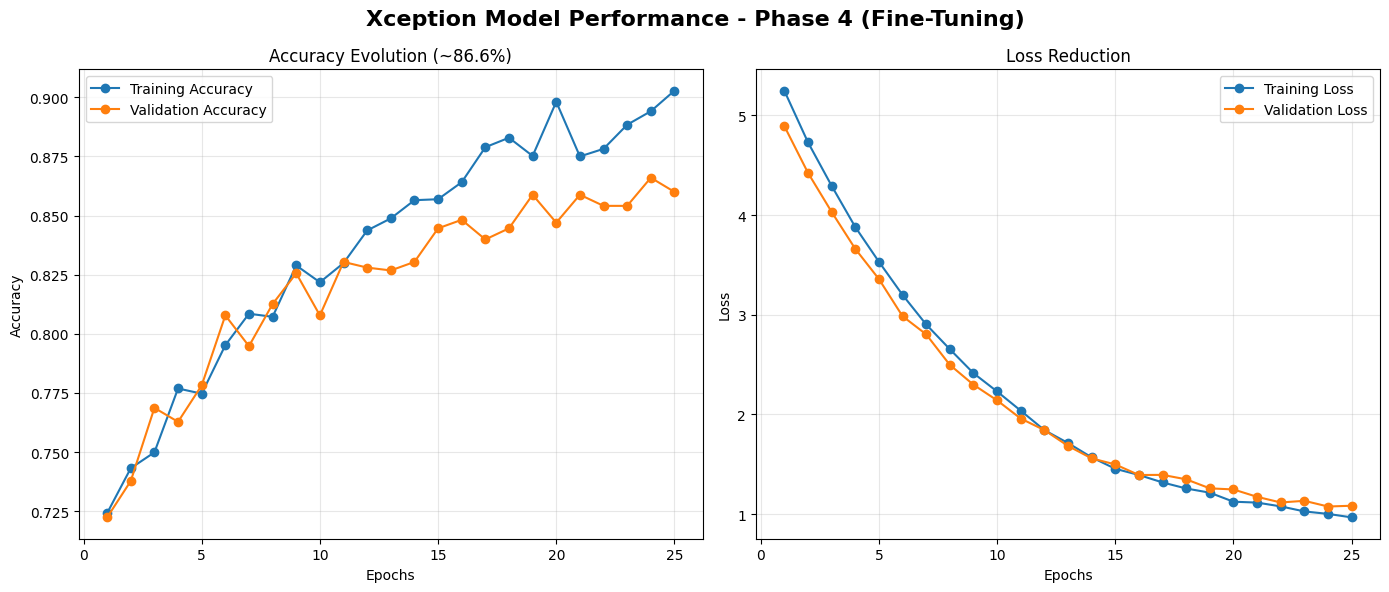

In [ ]:
import matplotlib.pyplot as plt

# Data extracted manually from Phase 4 logs
epochs = range(1, 26)

# Accuracy
acc = [
    0.7242, 0.7432, 0.7499, 0.7769, 0.7747,
    0.7952, 0.8085, 0.8072, 0.8289, 0.8218,
    0.8299, 0.8437, 0.8488, 0.8565, 0.8569,
    0.8641, 0.8789, 0.8829, 0.8752, 0.8981,
    0.8750, 0.8782, 0.8884, 0.8941, 0.9028
]

val_acc = [
    0.7224, 0.7378, 0.7687, 0.7628, 0.7782,
    0.8078, 0.7948, 0.8126, 0.8256, 0.8078,
    0.8304, 0.8280, 0.8268, 0.8304, 0.8446,
    0.8482, 0.8399, 0.8446, 0.8588, 0.8470,
    0.8588, 0.8541, 0.8541, 0.8660, 0.8600
]

# Loss
loss = [
    5.2476, 4.7297, 4.2935, 3.8801, 3.5316,
    3.1991, 2.9021, 2.6542, 2.4135, 2.2298,
    2.0375, 1.8421, 1.7125, 1.5691, 1.4542,
    1.3920, 1.3172, 1.2565, 1.2143, 1.1238,
    1.1149, 1.0769, 1.0264, 1.0015, 0.9665
]

val_loss = [
    4.8926, 4.4237, 4.0315, 3.6611, 3.3580,
    2.9852, 2.8030, 2.4969, 2.2977, 2.1406,
    1.9582, 1.8424, 1.6836, 1.5584, 1.4977,
    1.3918, 1.3930, 1.3484, 1.2578, 1.2468,
    1.1728, 1.1161, 1.1328, 1.0756, 1.0834
]

# Plotting
plt.figure(figsize=(14, 6))

# Main Title (The Model Name)
plt.suptitle('Xception Model Performance - Phase 4 (Fine-Tuning)', fontsize=16, fontweight='bold')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution (~86.6%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Reduction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Saved xception_performance_phase4.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading...


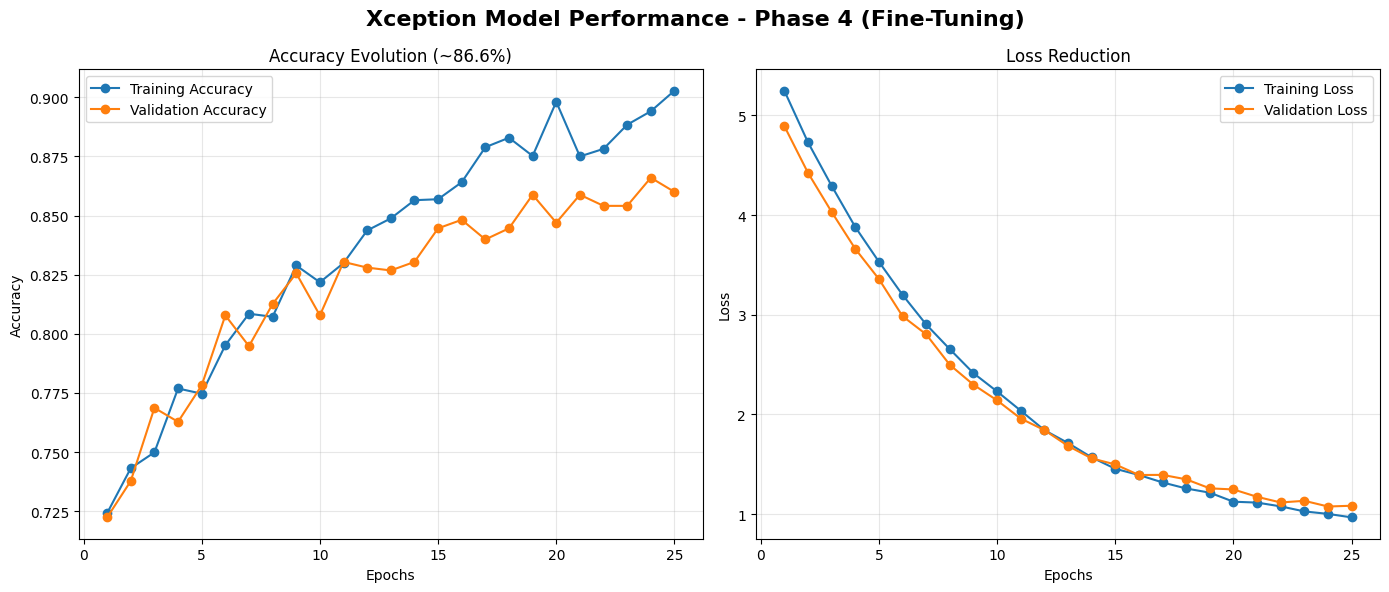

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

# --- 1. Define Data (Same as before) ---
epochs = range(1, 26)
acc = [0.7242, 0.7432, 0.7499, 0.7769, 0.7747, 0.7952, 0.8085, 0.8072, 0.8289, 0.8218, 0.8299, 0.8437, 0.8488, 0.8565, 0.8569, 0.8641, 0.8789, 0.8829, 0.8752, 0.8981, 0.8750, 0.8782, 0.8884, 0.8941, 0.9028]
val_acc = [0.7224, 0.7378, 0.7687, 0.7628, 0.7782, 0.8078, 0.7948, 0.8126, 0.8256, 0.8078, 0.8304, 0.8280, 0.8268, 0.8304, 0.8446, 0.8482, 0.8399, 0.8446, 0.8588, 0.8470, 0.8588, 0.8541, 0.8541, 0.8660, 0.8600]
loss = [5.2476, 4.7297, 4.2935, 3.8801, 3.5316, 3.1991, 2.9021, 2.6542, 2.4135, 2.2298, 2.0375, 1.8421, 1.7125, 1.5691, 1.4542, 1.3920, 1.3172, 1.2565, 1.2143, 1.1238, 1.1149, 1.0769, 1.0264, 1.0015, 0.9665]
val_loss = [4.8926, 4.4237, 4.0315, 3.6611, 3.3580, 2.9852, 2.8030, 2.4969, 2.2977, 2.1406, 1.9582, 1.8424, 1.6836, 1.5584, 1.4977, 1.3918, 1.3930, 1.3484, 1.2578, 1.2468, 1.1728, 1.1161, 1.1328, 1.0756, 1.0834]

# --- 2. Create Plot ---
plt.figure(figsize=(14, 6))
plt.suptitle('Xception Model Performance - Phase 4 (Fine-Tuning)', fontsize=16, fontweight='bold')

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Accuracy Evolution (~86.6%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Reduction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# --- 3. Save & Download ---
filename = 'xception_performance_phase4.jpg'
plt.savefig(filename, dpi=300) # Save high quality
print(f"Saved {filename}")

files.download(filename) # Trigger download
print("Downloading...")

plt.show() # Show it too

In [ ]:
from google.colab import files

print("Downloading Xception Model (86.6%)...")
files.download('xception_final_boost.h5')

print("Downloading EfficientNet Model (83.6%)...")
try:
    files.download('best_model.keras')
except:
    print("Could not find best_model.keras to download currently.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Could not find best_model.keras to download currently.


In [ ]:
# ==========================================
# FINAL STAGE: POWERHOUSE ENSEMBLE (Xception + EfficientNet)
# ==========================================
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

print('='*50)
print('STARTING POWERHOUSE ENSEMBLE')
print('='*50)

# 1. SETUP TEST SET (Ordered, Shuffle=False)
data_dir = "/content/enhanced_dataset" # Make sure this matches your folder
BATCH_SIZE = 32
IMG_SIZE = 224

print("Creating Ordered Test Set...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=999,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False # CRITICAL: Must be false to match labels
)

# True Labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 2. LOAD MODELS
print("\nLoading Models...")
models_loaded = []

# A. Load Xception (86.6%)
try:
    # Use the cleaned variable 'new_model' if it's in memory
    # Otherwise try loading the file
    if 'new_model' in globals():
        model_xception = new_model
        print("✅ Loaded Xception (from memory)")
    else:
        model_xception = load_model('xception_final_boost.h5')
        print("✅ Loaded Xception (from file)")
    models_loaded.append(('xception', model_xception))
except Exception as e:
    print(f"❌ Error loading Xception: {e}")

# B. Load EfficientNet (83.6%)
try:
    model_eff = load_model('best_model.keras')
    print("✅ Loaded EfficientNet (best_model.keras)")
    models_loaded.append(('efficientnet', model_eff))
except Exception as e:
    print(f"❌ Error loading EfficientNet: {e}")
    print("   Make sure 'best_model.keras' is in the files tab!")

if not models_loaded:
    raise ValueError("No models loaded! Please check your files.")

# 3. GENERATE PREDICTIONS
print("\nGenerating Predictions...")
preds = []

# Get predictions from each model
for name, model in models_loaded:
    print(f"   Predicting with {name}...")
    p = model.predict(test_ds, verbose=1)
    preds.append(p)

# 4. WEIGHTED ENSEMBLE
# Xception is slightly better (86% vs 83%), so we give it slightly more vote
# Weights: 0.6 for Xception, 0.4 for EfficientNet
if len(preds) == 2:
    print("\nCombining: 60% Xception + 40% EfficientNet")
    ensemble_pred = (0.6 * preds[0]) + (0.4 * preds[1])
else:
    print("\nUsing single model prediction")
    ensemble_pred = preds[0]

# 5. FINAL EVALUATION
ensemble_classes = np.argmax(ensemble_pred, axis=1)
acc = accuracy_score(y_true, ensemble_classes)

print('='*50)
print(f"🏆 FINAL ENSEMBLE ACCURACY: {acc*100:.2f}%")
print('='*50)
print(classification_report(y_true, ensemble_classes))